## Multiple plots

- This notebook plots the raw lightcurve and mad applied lightcurve to see if the cleaning process has worked well.
- After, we revisit the MAD plots to see if the edge of lightcurve effects (flux high/low) were removed.
- We plot cadence vs bit to observe the flags given by `eleanor` for this lightcurve

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
from analysis_tools_cython import *
from post_processing_tools import *
from astropy.stats import sigma_clip,sigma_clipped_stats
from astropy.table import Table
import pandas as pd
import glob
from astropy.table import unique

In [3]:
data = get_output('output_s6_corr.txt')

In [4]:
mad_df = pd.read_json("./data/Sectors_MAD.json")
sec = 6
clip = 4

In [5]:
mad_df

,1-1,1-2,1-3,1-4,2-1,2-2,2-3,2-4,3-1,3-2,...,24-3,24-4,25-1,25-2,25-3,25-4,26-1,26-2,26-3,26-4
0,0.001489,0.001328,0.001703,0.002827,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.002134,0.002945,0.002894,0.003199,0.002653,0.003018,0.002630,0.001581
1,0.000994,0.000875,0.001072,0.001785,0.001056,0.001361,0.001337,0.002266,NaN,NaN,...,0.003243,0.006123,NaN,NaN,NaN,NaN,0.001349,0.001644,0.001562,0.001166
2,0.000740,0.000646,0.000782,0.001198,0.000817,0.001098,0.000870,0.001513,NaN,NaN,...,0.002234,0.004026,0.001311,0.001514,0.001804,0.001894,0.000776,0.000929,0.001316,0.000691
3,0.000797,0.000751,0.000873,0.001351,0.000664,0.000993,0.000612,0.002648,NaN,NaN,...,0.001458,0.001920,0.000976,0.000829,0.001314,0.001426,NaN,NaN,NaN,NaN
4,0.000793,0.000734,0.000847,0.001323,0.000689,0.000966,0.000715,0.001990,NaN,NaN,...,0.002027,0.002430,0.001140,0.000941,0.002351,0.001402,0.001231,0.001119,0.001168,0.000650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
table,_=import_XRPlightcurve('betapic/tesslcs_sector_6_104_2_min_cadence_targets_tesslc_270577175.pkl',sector=6,clip=4, drop_bad_points=False)
mad_arr = mad_df.loc[:len(table)-1, f"{6}-{1}"]
print(len(table))

903


In [7]:
mad_arr

0      0.001269
1      0.001208
2      0.001161
3      0.001198
4      0.001253
         ...   
898    0.000656
899    0.000677
900    0.000672
901    0.000691
902    0.000658
Name: 6-1, Length: 903, dtype: float64

In [8]:
data.file

0          tesslc_234556256.pkl
1          tesslc_167974071.pkl
2          tesslc_255700743.pkl
3          tesslc_445939140.pkl
4          tesslc_176615627.pkl
                   ...         
2779720    tesslc_220211279.pkl
2779721    tesslc_206895034.pkl
2779722    tesslc_172778639.pkl
2779723     tesslc_79690705.pkl
2779724    tesslc_220479588.pkl
Name: file, Length: 2779725, dtype: object

In [9]:
path = '/storage/astro2/phrdhx/tesslcs'

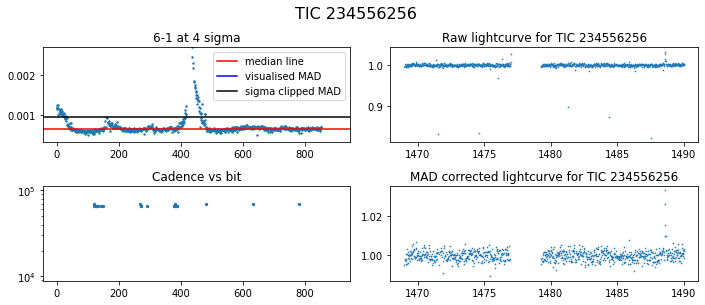

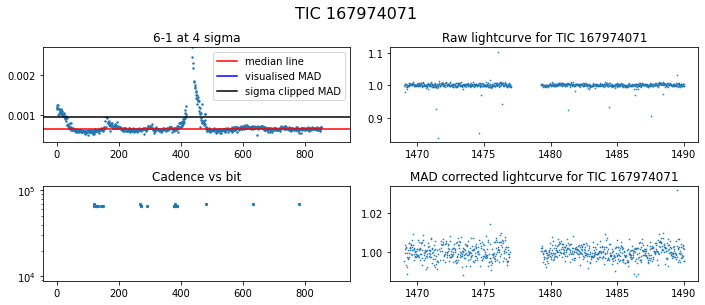

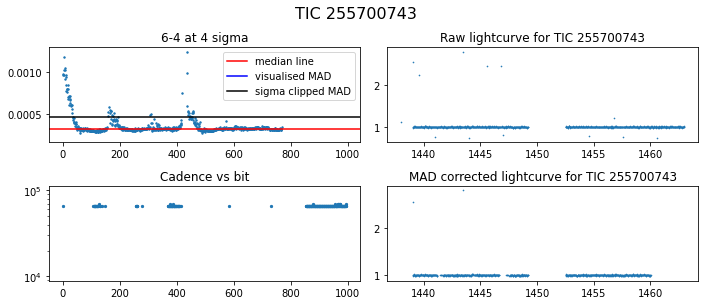

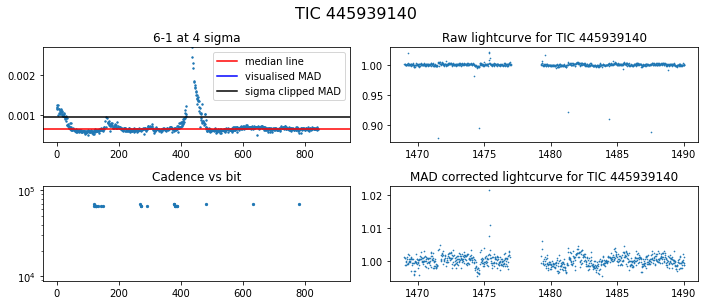

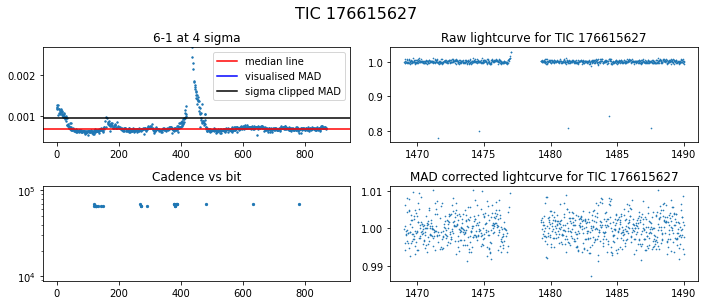

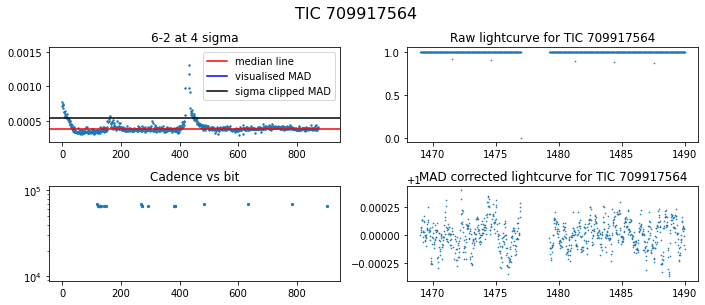

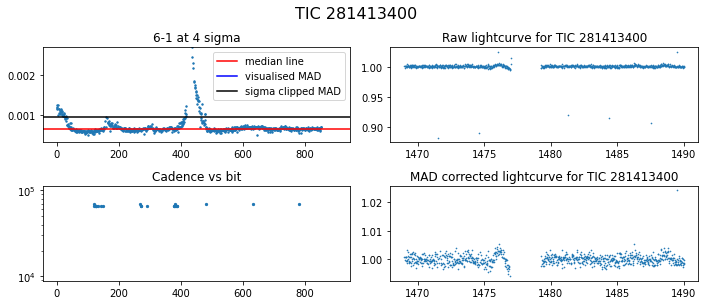

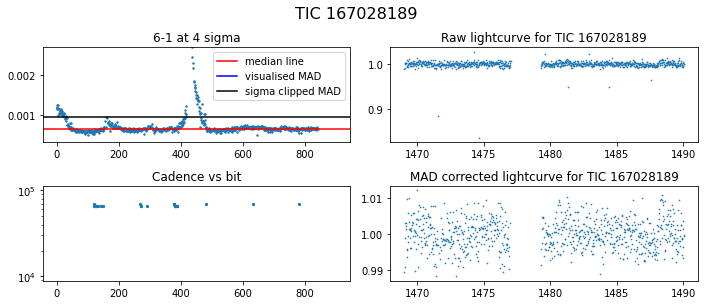

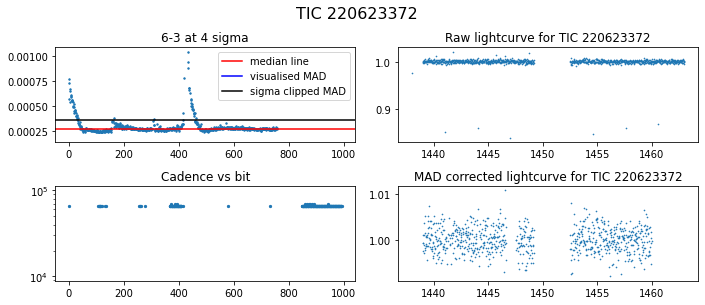

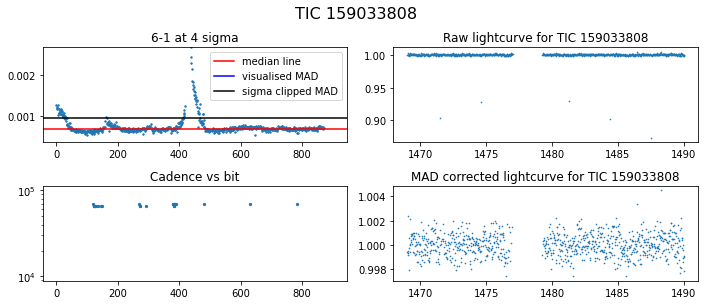

In [10]:
get_lightcurves(data.head(10),path,sec=sec,mad_df=mad_df,plots=True)

### Interpretations:

- MAD excludes data as expected.
- However, some expected points still don't get captured in the processing. After tightening sigma clipping, still the case. Maybe these are just anomalous points that we can do nothing about?

In [11]:
import os

In [12]:
os.listdir(path)

['tesslcs_sector_4_104',
 'tesslcs_sector_5_104',
 'tesslcs_sector_6_104',
 'tesslcs_sector_7_104',
 'tess_s6_tasoc']

In [13]:
for i in data.file.head(10):
    os.listdir(i)

FileNotFoundError: [Errno 2] No such file or directory: 'tesslc_234556256.pkl'